# 04. Survey Results
This notebook takes the results from the labeling and analyzes the statistics of where banding is most prevalent and uses the data to generate Figure 1 from the main text. This notebook also exports Supplementary Table 3, a clean export of the most important data from the core survey.

## Setup
### Import Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import rioxarray
import netCDF4
from IPython.display import clear_output
import seaborn as sns
import geopandas as gpd

### Set Paths

In [4]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'
shapefile_path='/Users/danielbabin/GitHub/Green_Bands/Data/Shapefiles/'
environmental_data='/Users/danielbabin/GitHub/Green_Bands/Data/Environmental/'
supplementary_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'

## Parse survey results

### Import Survey Data

#### Metadata
This is the table from before the labeling process

In [5]:
processed=pd.read_csv(checkpoints_path+'core_survey.csv')

#### Survey Results
This is the table with results from the labeling process, sourced from the previous notebook (03.)

In [6]:
survey=pd.read_csv(checkpoints_path+'survey_cores_results_scrambled.csv',index_col='N').sort_index()
survey=survey[survey['Label'].isnull()==False].copy()
survey['Label']=survey['Label'].astype(int).astype(str)
survey=pd.concat([processed,survey['Label']],axis=1)
survey=survey[survey['Label'].isnull()==False].copy()

survey_no_dup_ids=survey[survey['Code'].duplicated()==False].index
survey=survey.loc[survey_no_dup_ids].copy()

survey=survey.loc[survey[['Longitude','Latitude']].dropna().index].copy()
survey.loc[3433:3436,'Longitude']=142.783
survey.loc[3430:3432,'Longitude']=142.783
survey.loc[3128:3129,'Longitude']=-61.95

### Import Longhurst Zones and find zone for each core
This is useful because we will be counting banded sites by their region.

In [7]:
zones = gpd.read_file(shapefile_path+"Longhurst_Zones/Longhurst_world_v4_2010.shp")
joined_gdf = gpd.sjoin(gpd.GeoDataFrame(survey, 
                                        geometry=gpd.points_from_xy(survey.Longitude, 
                                                                    survey.Latitude,crs="epsg:4326")), 
                       zones)
survey['Longhurst Zone']=joined_gdf['ProvDescr']

### Split label codes
The results from the labeling process come in a single number (i.e. 8725). Each number relates to the appearance of a feature in the core. This code splits these into true-false values in unique columns.

In [8]:
for i in range(10):
    survey[i]=None
    strnum=str(i)
    survey[i]=[strnum in j for j in survey['Label']]

## Grouping banded sites
### By diagenetic characteristics

In [9]:
trans_banded=survey[(survey[2]==True)&(survey[7]==True)].copy()
deep=survey[(survey[7]==True)].copy()
shallow=survey[(survey[8]==True)].copy()
no_change=survey[(survey[7]==False)&(survey[8]==False)].copy()
banded=survey[(survey[2]==True)].copy()
no_bands=survey[(survey[1]==False)&(survey[2]==False)&(survey[3]==False)].copy()
green_layers=survey[(survey[4]==True)].copy()
any_bands=survey[(survey[1]==True)|(survey[2]==True)|(survey[4]==True)|(survey[5]==True)].copy()

survey['Transition Depth']=np.nan
survey.loc[(survey[7]==True),'Transition Depth']='Deep'
survey.loc[(survey[8]==True),'Transition Depth']='Shallow'
survey.loc[(survey[7]==False)&(survey[8]==False),'Transition Depth']='None'

survey['Banded']=np.nan
survey.loc[(survey[2]==True)|(survey[1]==True),'Banded']=True
survey.loc[(survey[1]==False)&(survey[2]==False)&(survey[3]==False),'Banded']=False

survey['Bands Present']=np.nan
survey.loc[(survey[2]==True)|(survey[1]==True)|(survey[4]==True)|(survey[5]==True),'Bands Present']=True
survey.loc[(survey[2]==False)&(survey[1]==False)&(survey[4]==False)&(survey[5]==False),'Bands Present']=False

In [10]:
cols=['Code','Latitude','Longitude','Water depth (m)','CaCO3 (%)','Bottom Water Oxygen (umol/L)','BWO (Dutk)',
      'Deep Water Oxygen Water Column Average (umol/L)','MAR (g/cm2/y)','SR (cm/ka)','SR (Dutk)','Organic Carbon (%)',
      'Label']

In [11]:
survey['Transition Depth'].value_counts()

None       1716
Shallow     229
Deep        176
Name: Transition Depth, dtype: int64

### By geographic location

In [12]:
# len(atl_zones)+len(pac_zones)+len(ind_zones)+len(antarctic_zones)+len(arctic_zones)

In [13]:
atl_zones=['Trades - Caribbean Province','Trades - N. Atlantic Tropical Gyral Province (TRPG)',
          'Westerlies - N. Atlantic Subtropical Gyral Province (West) (STGW)',
          'Trades - Eastern Tropical Atlantic Province',
          'Trades - South Atlantic Gyral Province (SATG)','Trades - Western Tropical Atlantic Province',
          'Polar - Atlantic Arctic Province','Westerlies - Mediterranean Sea, Black Sea Province',
          'Westerlies - N. Atlantic Subtropical Gyral Province (East) (STGE)',
          'Polar - Atlantic Subarctic Province',
          'Westerlies - N. Atlantic Drift Province (WWDR)','Coastal - Guianas Coastal Province',
          'Coastal - Benguela Current Coastal Province','Coastal - NW Atlantic Shelves Province',
          'Coastal - Canary Coastal Province (EACB)','Coastal - Guinea Current Coastal Province',
          'Westerlies - Gulf Stream Province']
pac_zones=['Coastal - California Upwelling Coastal Province','Westerlies - N. Pacific Polar Front Province',
           'Trades - N. Pacific Tropical Gyre Province',
           'Westerlies - N. Pacific Subtropical Gyre Province (West)','Trades - W. Pacific Warm Pool Province',
           'Trades - N. Pacific Equatorial Countercurrent Province',
           'Trades - Pacific Equatorial Divergence Province','Westerlies - S. Pacific Subtropical Gyre Province',
           'Coastal - Chile-Peru Current Coastal Province',
           'Westerlies - Pacific Subarctic Gyres Province (East)','Polar - N. Pacific Epicontinental Province',
           'Trades - Archipelagic Deep Basins Province','Westerlies - Tasman Sea Province',
           'Westerlies - Kuroshio Current Province',
           'Westerlies - Pacific Subarctic Gyres Province (West)','Coastal - Central American Coastal Province',
           'Coastal - Sunda-Arafura Shelves Province',
           'Coastal - East Australian Coastal Province','Coastal - New Zealand Coastal Province',
           'Coastal - China Sea Coastal Province','Coastal - Alaska Downwelling Coastal Province']
ind_zones=['Trades - Indian Monsoon Gyres Province','Trades - Indian S. Subtropical Gyre Province',
           'Coastal - NW Arabian Upwelling Province','Coastal - Red Sea, Persian Gulf Province',
           'Coastal - E. Africa Coastal Province','Coastal - Australia-Indonesia Coastal Province',
           'Coastal - E. India Coastal Province']
antarctic_zones=['Westerlies - S. Subtropical Convergence Province',
                 'Polar - Antarctic Province', 'Polar - Austral Polar Province',
                 'Westerlies - Subantarctic Province']
arctic_zones=['Polar - Boreal Polar Province (POLR)']


#### How many banded cores were found in each ocean basin?

In [14]:
banded_atl=banded.loc[survey['Longhurst Zone'].isin(atl_zones)]
banded_pac=banded.loc[survey['Longhurst Zone'].isin(pac_zones)] # 2 sea of japan, 4 australian margin, 1 chile, 2 alaksa
banded_ind=banded.loc[survey['Longhurst Zone'].isin(ind_zones)] # 6 coastal se africa, 4 bay of bengal/IO
banded_ant=banded.loc[survey['Longhurst Zone'].isin(antarctic_zones)] # 3 in atlantic sector, one in ross sea
banded_arc=banded.loc[survey['Longhurst Zone'].isin(arctic_zones)] # 2 in atlantic sector

In [15]:
oceans_names=['Atlantic','Pacific','Indian','Antarctic','Arctic']
for i,df in enumerate([banded_atl,banded_pac,banded_ind,banded_ant,banded_arc]):
    print(oceans_names[i]+':',len(df),'banded cores')

Atlantic: 108 banded cores
Pacific: 9 banded cores
Indian: 10 banded cores
Antarctic: 4 banded cores
Arctic: 2 banded cores


#### How many sites had banding in each basin?
There are often multiple cores from a single site.

In [16]:
oceans_names=['Atlantic','Pacific','Indian','Antarctic','Arctic']
for i,df in enumerate([banded_atl,banded_pac,banded_ind,banded_ant,banded_arc]):
    print(oceans_names[i]+':',len(df.groupby(by='Site')),'sites with banding')

Atlantic: 67 sites with banding
Pacific: 7 sites with banding
Indian: 6 sites with banding
Antarctic: 3 sites with banding
Arctic: 1 sites with banding


#### How many unique sites and cores were surveyed from each basin?
##### Atlantic

In [17]:
survey_atl=survey.loc[survey['Longhurst Zone'].isin(atl_zones)]
sites_surveyed_atl=survey_atl['Site'].unique()

In [18]:
print(len(sites_surveyed_atl),'sites','\n'+str(len(survey_atl)),'cores')

369 sites 
673 cores


##### Pacific

In [19]:
survey_pac=survey.loc[survey['Longhurst Zone'].isin(pac_zones)]
sites_surveyed_pac=survey_pac['Site'].unique()

In [20]:
print(len(sites_surveyed_pac),'sites','\n'+str(len(survey_pac)),'cores')

538 sites 
981 cores


##### Indian

In [21]:
survey_ind=survey.loc[survey['Longhurst Zone'].isin(ind_zones)]
sites_surveyed_ind=survey_ind['Site'].unique()

In [22]:
print(len(sites_surveyed_ind),'sites','\n'+str(len(survey_ind)),'cores')

132 sites 
234 cores


##### Arctic

In [23]:
survey_arc=survey.loc[survey['Longhurst Zone'].isin(arctic_zones)]
sites_surveyed_arc=survey_arc['Site'].unique()

In [24]:
print(len(sites_surveyed_arc),'sites','\n'+str(len(survey_arc)),'cores')

11 sites 
20 cores


##### Southern

In [25]:
survey_ant=survey.loc[survey['Longhurst Zone'].isin(antarctic_zones)]
sites_surveyed_ant=survey_ant['Site'].unique()

In [26]:
print(len(sites_surveyed_ant),'sites','\n'+str(len(survey_ant)),'cores')

115 sites 
213 cores


## Make figure

### Import Bottow Water Oxygen
the whole world ocean atlas file was too big to upload to github so I am uploading presliced versions here

In [47]:
# o_woa=xr.open_dataset(environmental_data+'woa18_all_o00_01.nc',decode_times=False)
# variable_masked = np.ma.masked_invalid(o_woa['o_an'].values)
# depth_index = np.nanargmax(variable_masked, axis=1)
# depth_index = xr.DataArray(depth_index,dims=('depth','lat', 'lon'))
# bwo_woa = o_woa.isel(depth=depth_index)
# bwo_woa[['o_an','lat','lon']].drop_vars(['depth']).to_netcdf(environmental_data+'woa_bottom.nc')

In [52]:
bwo_woa=xr.open_dataset(environmental_data+'woa_bottom.nc',decode_times=False)

In [54]:
survey['Water depth (km)']=survey['Water depth (m)']/1000

In [55]:
from matplotlib.gridspec import GridSpec

In [56]:
violin_colors=sns.color_palette('magma',10)
violin_colors

[(0.069764, 0.049726, 0.193735),
 (0.198177, 0.063862, 0.404009),
 (0.347636, 0.082946, 0.494121),
 (0.494258, 0.141462, 0.507988),
 (0.639216, 0.189921, 0.49415),
 (0.786212, 0.241514, 0.450184),
 (0.913354, 0.330052, 0.382563),
 (0.979645, 0.491014, 0.367783),
 (0.996341, 0.660969, 0.45116),
 (0.995131, 0.827052, 0.585701)]

In [57]:
violin_color1=violin_colors[3]
violin_color2=violin_colors[-3]

In [58]:
import matplotlib.patches as patches
import matplotlib.path as mpath

In [59]:
survey.loc[survey['Banded']==True,'Banded']='Present'
survey.loc[survey['Banded']==False,'Banded']='Absent'

### Make north-south Atlantic hydrographic section

In [72]:
# atlns_cs=o_woa.sel(lon=slice(-25,-23),lat=slice(-80,70)).mean(dim='time').mean(dim='lon')['o_an']
# atlns_cs=o_woa.sel(lon=slice(-30,-10),lat=slice(-80,70)).mean(dim='time').mean(dim='lon')['o_an']

In [74]:
atlns_cs=xr.open_dataset(environmental_data+'atlns_cs.nc',decode_times=False)['o_an']

In [75]:
import matplotlib.patches as mpatches

In [76]:
not_banded = pd.concat([survey_atl[survey_atl['Banded'] == False],survey_ant[survey_ant['Banded'] == False]])
banded = pd.concat([survey_atl[survey_atl['Banded'] == True],survey_ant[survey_ant['Banded'] == True]])

Text(0, 0.5, 'Depth (m)')

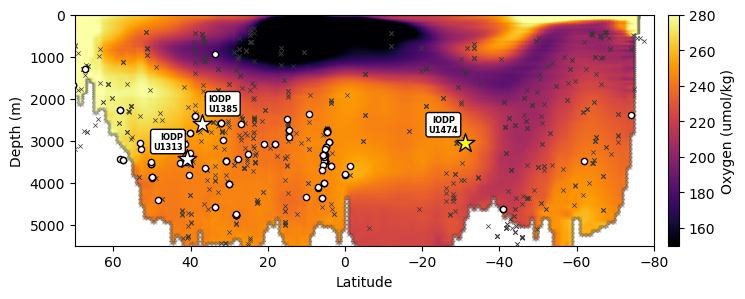

In [77]:
fig,ax=plt.subplots(figsize=(9,3))
cax=ax.pcolormesh(atlns_cs.lat.values,atlns_cs.depth.values,atlns_cs,
                  vmin=150,vmax=280,shading='gouraud',cmap='inferno')
cbar=plt.colorbar(cax,ax=ax,label='Oxygen (umol/kg)', orientation='vertical', pad=0.02)

ax.scatter(not_banded.Latitude, not_banded['Water depth (m)'], marker='x', s=10, color='xkcd:dark grey', lw=.5, zorder=5)
ax.scatter(banded.Latitude, banded['Water depth (m)'], s=20, color='w', edgecolor='k', lw=1, zorder=5)

ax.scatter([-31.2167],[3045],marker='*',s=200, zorder=10,color='yellow',ec='k',lw=1) #### U1474
ax.text(-25.5,2850,'IODP\nU1474',fontweight='bold',ha='center',va='bottom',
        bbox=dict(boxstyle="round",ec=(0,0,0),fc=(1,1,1),clip_on=True),size=6,zorder=10)
ax.scatter([41],[3426],marker='*',s=200, zorder=10,color='w',ec='k',lw=1) #### U1313
ax.text(42,3250,'IODP\nU1313',fontweight='bold',ha='right',va='bottom',
        bbox=dict(boxstyle="round",ec=(0,0,0),fc=(1,1,1),clip_on=True),size=6,zorder=10)
ax.scatter([37],[2592],marker='*',s=200, zorder=10,color='w',ec='k',lw=1) #### U1385
ax.text(35.5,2350,'IODP\nU1385',fontweight='bold',ha='left',va='bottom',
        bbox=dict(boxstyle="round",ec=(0,0,0),fc=(1,1,1),clip_on=True),size=6,zorder=10)

ax.set_xlim(70,-80)
ax.set_ylim(atlns_cs.depth.values.max(),0)
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')

### Map, violins, cross section

In [36]:
deep_survey=survey[survey['Water depth (m)']>1500].copy()

In [37]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

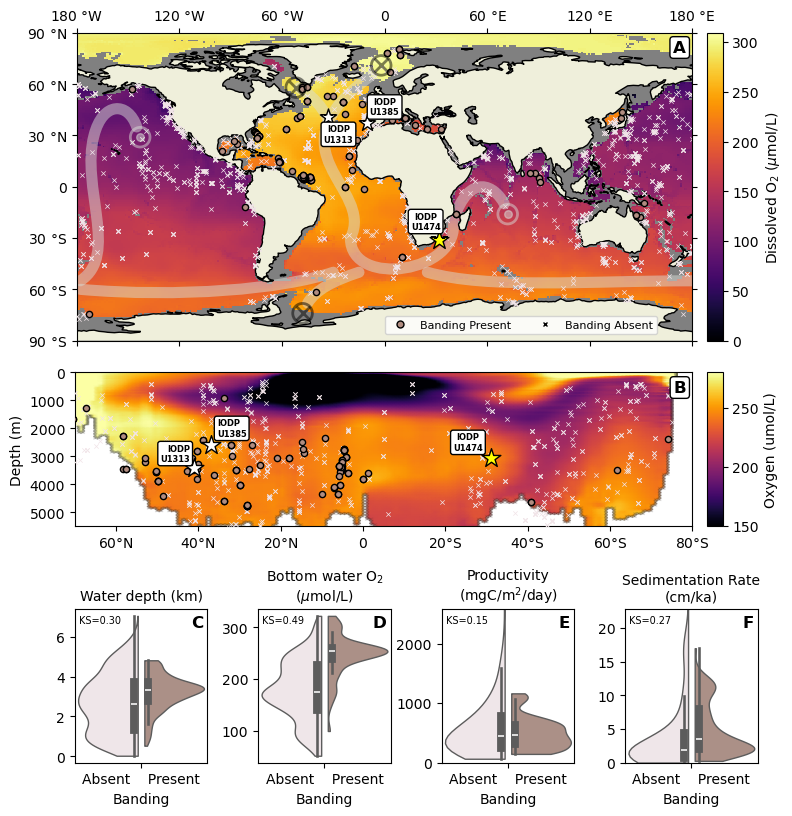

In [88]:
fig = plt.figure(figsize=(8, 8.2), facecolor='w')
proj = ccrs.PlateCarree()

gs = GridSpec(4, 13, height_ratios=[16, 8, 1, 8],wspace=5)

# Create the top left panel for the world map
axt = fig.add_subplot(gs[0, :], projection=proj)
axm = fig.add_subplot(gs[1, :])
axll = fig.add_subplot(gs[3, 0:3])
axlml = fig.add_subplot(gs[3, 3:6])
axlmr = fig.add_subplot(gs[3, 6:9])
axlr = fig.add_subplot(gs[3, 9:12])

######################################################################################################################### MAP
d=bwo_woa.plot(ax=axt, transform=ccrs.PlateCarree(), color='grey',add_colorbar=False,zorder=0)
# d = bwo_woa.plot(ax=axt, transform=ccrs.PlateCarree(), cmap='inferno',add_colorbar=False)
d=o_woa['o_an'].sel(depth=slice(1500,4000)).mean(dim='depth').plot(ax=axt, transform=ccrs.PlateCarree(), cmap='inferno',
                                                                   add_colorbar=False,zorder=1,vmin=0)


# Define the control points for the curved arrow
control_points_IO = [[-8, 65], [-70, 20], [-5, 0], [-20, -30], [-20, -60],
                     [45, -50], [40, -20], [50, 10], [65, 0], [70, -10]]
control_points_WS = [[-45, -68], [-40, -60], [-30, -55], [-15, -50]]
control_points_SOE = [[25, -50], [60, -60], [120, -55], [180, -55]]
control_points_PO = [[-178, -55], [-155, -40], [-178, 0], [-170, 30], [-165, 50], [-150, 50], [-145, 35]]
control_points_SOW = [[-178, -60], [-120, -65], [-60, -60], [-30, -50]]
control_points_LSW = [[-50,58],[-40,52],[-30,40],[-32,30]]

cps=[control_points_IO, control_points_SOE, control_points_SOW, control_points_PO, control_points_WS,control_points_LSW]

# Create the curved path using cubic Bezier curves for the Indian Ocean arrow
for cp in cps:
    path = mpath.Path(np.array(cp), [mpath.Path.MOVETO] + [mpath.Path.CURVE4] * (len(cp) - 1))
    patch = patches.FancyArrowPatch(
        path=path, arrowstyle='-', lw=8, edgecolor='xkcd:light grey', alpha=.5, 
        transform=ccrs.PlateCarree(), zorder=1)
    axt.add_patch(patch)
    cp_lon, cp_lat = zip(*cp)
    # axt.scatter(cp_lon, cp_lat, c='blue', marker='o', s=50, transform=ccrs.PlateCarree())
    
## upwelling
axt.scatter([control_points_IO[-1][0]+2,control_points_PO[-1][0]+2],
            [control_points_IO[-1][1]-6,control_points_PO[-1][1]-6],
            color='xkcd:light grey', alpha=.5, transform=ccrs.PlateCarree(), marker='o', s=30, zorder= 10)
axt.scatter([control_points_IO[-1][0]+2,control_points_PO[-1][0]+2],
            [control_points_IO[-1][1]-6,control_points_PO[-1][1]-6],
            ec='xkcd:light grey', fc='none', alpha=.5, transform=ccrs.PlateCarree(), marker='o', s=200, zorder= 10, lw=2)
## deep water
axt.scatter([control_points_LSW[0][0]-2,control_points_IO[0][0]+6,control_points_WS[0][0]-3],
            [control_points_LSW[0][1]+0,control_points_IO[0][1]+6,control_points_WS[0][1]-6],
            color='k', alpha=.5, transform=ccrs.PlateCarree(), marker='x', s=100, zorder= 10, lw=2)
axt.scatter([control_points_LSW[0][0]-2,control_points_IO[0][0]+6,control_points_WS[0][0]-3],
            [control_points_LSW[0][1]+0,control_points_IO[0][1]+6,control_points_WS[0][1]-6],
            ec='k', fc='none', alpha=.5, transform=ccrs.PlateCarree(), marker='o', s=200, zorder= 10, lw=2)

# coastlines
axt.add_feature(cfeature.LAND, zorder=2)
axt.add_feature(cfeature.COASTLINE, zorder=3)
axt.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
axt.set_title('')


not_banded = survey[survey['Banded'] == 'Absent']
banded = survey[survey['Banded'] == 'Present']
axt.scatter(not_banded.Longitude, not_banded.Latitude, marker='x', s=10, color='#F1E4E8', lw=.5, zorder=5)
axt.scatter(banded.Longitude, banded.Latitude, s=20, color='#B18D81', edgecolor='k', lw=1, zorder=5)

axt.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
axt.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
axt.set_xticklabels(['180 $\degree$W','120 $\degree$W','60 $\degree$W','0',
                     '60 $\degree$E','120 $\degree$E','180 $\degree$E'])
axt.set_yticklabels(['90 $\degree$S','60 $\degree$S','30 $\degree$S','0',
                     '30 $\degree$N','60 $\degree$N','90 $\degree$N'])
axt.xaxis.tick_top()
axt.xaxis.set_label_position('top')
axt.set_xlabel('')
axt.set_ylabel('')
axt.tick_params(axis='both',bottom=True,top=True,left=True,right=True)

# my sites
axt.scatter([31.54516667],[-31.2167],marker='*',s=200, zorder=10,color='yellow',ec='k',lw=1) #### U1474
axt.text(24,-26,'IODP\nU1474',transform=ccrs.Geodetic(),fontweight='bold',ha='center',va='bottom',
        bbox=dict(boxstyle="round",ec=(0,0,0),fc=(1,1,1),clip_on=True),size=6,zorder=10)
axt.scatter([-32.95666667],[41],marker='*',s=150, zorder=10,color='w',ec='k',lw=1) #### U1313
axt.text(-27,25,'IODP\nU1313',transform=ccrs.Geodetic(),fontweight='bold',ha='center',va='bottom',
        bbox=dict(boxstyle="round",ec=(0,0,0),fc=(1,1,1),clip_on=True),size=6,zorder=10)
axt.scatter([-10.12603333],[37.57141667],marker='*',s=150, zorder=10,color='w',ec='k',lw=1) #### U1385
axt.text(0,41,'IODP\nU1385',transform=ccrs.Geodetic(),fontweight='bold',ha='center',va='bottom',
        bbox=dict(boxstyle="round",ec=(0,0,0),fc=(1,1,1),clip_on=True),size=6,zorder=10)

legend_elements = [Line2D([0], [0], ms=5, marker='o', color='#B18D81', markeredgecolor='k', lw=1, ls='',label='Banding Present'),
                   Line2D([0], [0], marker='x', ms=3, color='k', lw=.5, ls='', label='Banding Absent')]
axt.legend(handles=legend_elements, loc=(.5,.02),fontsize=8,ncol=2)

################################################################################################ Hydrographic section
ax=axm

cax=ax.pcolormesh(atlns_cs.lat.values,atlns_cs.depth.values,atlns_cs,
                  vmin=150,vmax=280,shading='gouraud',cmap='inferno')
cbar=plt.colorbar(cax,ax=ax,label='Oxygen (umol/L)', orientation='vertical', pad=0.02,aspect=10)

not_banded = pd.concat([survey_atl[survey_atl['Banded'] == False],survey_ant[survey_ant['Banded'] == False]])
banded = pd.concat([survey_atl[survey_atl['Banded'] == True],survey_ant[survey_ant['Banded'] == True]])
ax.scatter(not_banded.Latitude, not_banded['Water depth (m)'], marker='x', s=10, color='#F1E4E8', lw=.5, zorder=5)
ax.scatter(banded.Latitude, banded['Water depth (m)'], s=20, color='#B18D81', edgecolor='k', lw=1, zorder=5)

ax.scatter([-31.2167],[3045],marker='*',s=200, zorder=10,color='yellow',ec='k',lw=1) #### U1474
ax.text(-25.5,2850,'IODP\nU1474',fontweight='bold',ha='center',va='bottom',
        bbox=dict(boxstyle="round",ec=(0,0,0),fc=(1,1,1),clip_on=True),size=6,zorder=10)
ax.scatter([41],[3426],marker='*',s=200, zorder=10,color='w',ec='k',lw=1) #### U1313
ax.text(42,3250,'IODP\nU1313',fontweight='bold',ha='right',va='bottom',
        bbox=dict(boxstyle="round",ec=(0,0,0),fc=(1,1,1),clip_on=True),size=6,zorder=10)
ax.scatter([37],[2592],marker='*',s=200, zorder=10,color='w',ec='k',lw=1) #### U1385
ax.text(35.5,2350,'IODP\nU1385',fontweight='bold',ha='left',va='bottom',
        bbox=dict(boxstyle="round",ec=(0,0,0),fc=(1,1,1),clip_on=True),size=6,zorder=10)

ax.set_xlim(70,-80)
ax.set_ylim(atlns_cs.depth.values.max(),0)
# ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')
ax.set_yticks([0,1000,2000,3000,4000,5000])
ax.set_xticks([60,40,20,0,-20,-40,-60,-80])
ax.set_xticklabels(['60$\degree$N','40$\degree$N','20$\degree$N','0','20$\degree$S','40$\degree$S','60$\degree$S',
                    '80$\degree$S'])


################################################################################################ Violin plots
my_pal = {'Present':'#B18D81', 'Absent':'#F1E4E8'}

# sns.violinplot(ax=ax, data=df, x="Banded", y="Bottom Water Oxygen (umol/L)", cut=0, bw=.3, 
#                palette=my_pal,order=[True,False])
ax = axll
sns.violinplot(ax=ax, data=survey, hue="Banded", y='Water depth (km)', cut=0, bw_method=.3, split=True,
               palette=my_pal,legend=False,width=1,gap=.1)
ax.set_title('Water depth (km)',fontsize=10)
ax.set_ylabel('')

ax = axlml
sns.violinplot(ax=ax, data=survey, hue="Banded", y="BWO Seiter", cut=0, bw_method=.3, split=True,
               palette=my_pal,legend=False,width=1,gap=.1)
ax.set_title('Bottom water O$_2$\n($\mu$mol/L)',fontsize=10)
ax.set_ylabel('')

ax = axlmr
sns.violinplot(ax=ax, data=survey, hue="Banded", y='Productivity Lee', cut=0, bw_method=.3, split=True,
               palette=my_pal,legend=False,width=1,gap=.1)
ax.set_title('Productivity\n(mgC/m$^2$/day)',fontsize=10)
ax.set_ylabel('')
ax.set_ylim(0,deep_survey.loc[deep_survey['Banded']=='Absent','Productivity Lee'].quantile(.99))

ax = axlr
sns.violinplot(ax=ax, data=survey, hue="Banded", y='SR Dutkiewicz', cut=0, bw_method=.3, split=True,
               palette=my_pal,legend=False,width=1,gap=.1)
ax.set_title('Sedimentation Rate\n(cm/ka)',fontsize=10)
ax.set_ylabel('')
ax.set_ylim(0,deep_survey.loc[deep_survey['Banded']=='Absent','SR Dutkiewicz'].quantile(.99))

for ax in [axll,axlml,axlmr,axlr]:
    ax.set_xlabel('Banding')
    ax.set_xticks([0])
    ax.set_xticklabels(['Absent    Present'])
    for element in ax.collections:
        # element.set_ec('k')
        element.set_lw(1)
    # for i in [5,6,2,1]:
        # ax.get_children()[i].set_color('k')


cbar = plt.colorbar(d, ax=axt, orientation='vertical', pad=0.02)
cbar.set_label('Dissolved O$_2$ ($\mu$mol/L)')

axt.annotate('A',xy=(.99,.977),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
axm.annotate('B',xy=(.99,.95),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'),zorder=10)
letters=['C','D','E','F']
for i,ax in enumerate([axll,axlml,axlmr,axlr]):
    ax.annotate(letters[i],xy=(.97,.96),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                     fontsize=12)


# plt.tight_layout()
plt.subplots_adjust(right=1.03,top=.96,bottom=.07,left=.1)
fig.savefig(figure_path+'Figure 1 - Global core top survey of banding.png',dpi=300)

## Statistical Significance

In [89]:
not_banded = survey[survey['Banded'] == 'Absent']
banded = survey[survey['Banded'] == 'Present']
kss=[]
ps=[]
for col in ['Water depth (km)','BWO Seiter','Productivity Lee','SR Dutkiewicz','OC Lee',
            'CaCO3 Archer','Holocene-LGM CaCO3 (%)']:
    ks,p=ks_2samp(not_banded[col], banded[col])
    kss.append(ks)
    ps.append(p)

In [91]:
ps

[4.922485467500652e-11,
 5.752784303778293e-29,
 0.006631650219654929,
 1.3368752592658738e-08,
 2.162800737223569e-11,
 2.633835883392028e-06,
 1.4601845405007352e-38]

In [90]:
kss

[0.30883660764815263,
 0.49812703802517044,
 0.14978305980003773,
 0.2715929608968658,
 0.3139030371627995,
 0.23065728838224595,
 0.5699733203977686]

## Other parameters

In [40]:
# depth_palette={'Deep':'#B18D81','Shallow': '#e3bfbf','None':'#F1E4E8'}
inferno=sns.color_palette('inferno',9)
depth_palette={'Deep':inferno[-1],'Shallow':inferno[6],'None':inferno[3]}

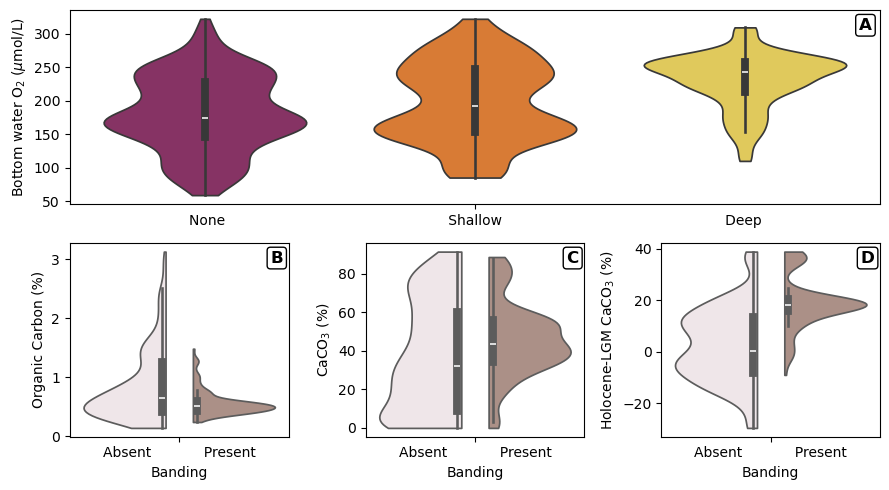

In [41]:
fig = plt.figure(figsize=(9, 5), facecolor='w')
proj = ccrs.PlateCarree()

gs = GridSpec(2, 3)

# Create the top left panel for the world map
axb = fig.add_subplot(gs[0,:])
axt0 = fig.add_subplot(gs[1,0])
axt1 = fig.add_subplot(gs[1,1])
axt2 = fig.add_subplot(gs[1,2])

axt=[axt0,axt1,axt2]

ax=axt[0]
sns.violinplot(ax=ax, data=deep_survey, hue="Banded", y='OC Lee', cut=0, bw_method=.3, split=True, 
               palette=my_pal,legend=False,width=1,gap=.25)
# ax.set_ylim(0,deep_survey.loc[deep_survey['Banded']=='Absent','Productivity Lee'].quantile(.95))
ax.set_ylabel('Organic Carbon (%)')

ax=axt[1]
sns.violinplot(ax=ax, data=deep_survey, hue="Banded", y='CaCO3 Archer', cut=0, bw_method=.3, split=True, 
               palette=my_pal,legend=False,width=1,gap=.25)
# ax.set_ylim(0,deep_survey.loc[deep_survey['Banded']=='Absent','OC Lee'].quantile(.95))
ax.set_ylabel('CaCO$_3$ (%)')

ax=axt[2]
sns.violinplot(ax=ax, data=deep_survey, hue="Banded", y='Holocene-LGM CaCO3 (%)', cut=0, bw_method=.3, split=True, 
               palette=my_pal,legend=False,width=1,gap=.25)
# ax.set_ylim(0,deep_survey.loc[deep_survey['Banded']=='Absent','SR Dutkiewicz'].quantile(.95))
ax.set_ylabel('Holocene-LGM CaCO$_3$ (%)')

for ax in axt:
    ax.set_xlabel('Banding')
    ax.set_xticks([0])
    ax.set_xticklabels(['Absent            Present'])
    # for element in ax.collections:
        # element.set_ec('k')
        # element.set_lw(1)
    # for i in [5,6,2,1]:
        # ax.get_children()[i].set_color('k')

ax=axb
sns.violinplot(ax=ax, data=deep_survey, hue="Transition Depth", y='BWO Seiter', cut=0, bw_method=.3, 
               palette=depth_palette,legend=False,width=1,gap=.25)
ax.set_ylabel('Bottom water O$_2$ ($\mu$mol/L)')

# ax.set_xlabel('Banding')
ax.set_xticks([0])
none='None                                                   '
ax.set_xticklabels([none+'Shallow                                                   Deep'])
# for element in ax.collections:
    # element.set_ec('k')
    # element.set_lw(1)
    # for i in [5,6,2,1]:
        # ax.get_children()[i].set_color('k')

axb.annotate('A',xy=(.99,.96),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                 fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
letters=['B','C','D']
for i,ax in enumerate([axt[0],axt[1],axt[2]]):
    ax.annotate(letters[i],xy=(.975,.96),ha='right',va='top',fontweight='bold',xycoords='axes fraction',
                     fontsize=12,bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

plt.tight_layout()
# plt.subplots_adjust(wspace=.6)
fig.savefig(supplementary_figure_path+'Extended Data Figure 2 - Global core top survey of banding.png',dpi=300)

## Export pretty table

In [42]:
keep_cols=['Era','Leg/Exp','Site','Hole','Latitude','Longitude','Water depth (m)',
           'Transition Depth',1,2,4,5,9,'BWO Seiter','CaCO3 Archer','Productivity Lee','OC Lee','SR Dutkiewicz']

### Clean stuff

In [43]:
export=survey[keep_cols].copy()

In [44]:
export.loc[export['Transition Depth']=='Shallow','Transition Depth']='Shallow (<40 cm)'
export.loc[export['Transition Depth']=='Deep','Transition Depth']='Deep (>40 cm)'

In [45]:
export=export.rename(columns={1:'Green bands assoc. with transition',
                              2:'Red bands assoc. with transition',
                              4:'Green bands deeper than transiition',
                              5:'Red bands deeper than transiition',
                              9:'Unusable image',
                              'BWO Seiter':'Bottomwater O2 (umol/L)',
                              'CaCO3 Archer':'CaCO3 (%)',
                              'Productivity Lee':'Productivity (mgC/m2/day)',
                              'OC Lee':'Organic Carbon (%)',
                              'SR Dutkiewicz':'Sedimentation Rate (cm/ka)'})

In [46]:
export.to_csv(table_path+'Supplementary Table 3 - Banding survey.csv',index=False)